In [2]:
%matplotlib inline

In [3]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import aiohttp
from datetime import datetime, timedelta
import csv
import pytz

In [4]:
data, SR = sf.read("brumm.wav")

In [5]:
snap_offset = timedelta(seconds=3*60+31)

In [6]:
STEP_RATE_S = 1 # in seconds, must match grid data sample rate

In [7]:
STEP_RATE_SAMPLES = int(SR * STEP_RATE_S)
seconds = np.array_split(data, len(data) / int(STEP_RATE_SAMPLES))
seconds = [np.concatenate([second[:STEP_RATE_SAMPLES], [0] * (STEP_RATE_SAMPLES - len(second))]) for second in seconds]
seconds = np.array(seconds)
seconds.shape

(318, 48000)

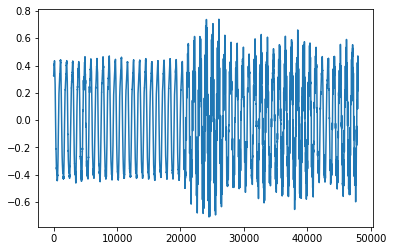

In [8]:
s = seconds[5]
plt.plot(s)

In [9]:
F_START = 49.95
F_STOP = 50.05
N_BANDS = 100

In [10]:
ts = np.linspace(0, STEP_RATE_S, STEP_RATE_SAMPLES)
fs = np.linspace(F_START, F_STOP, N_BANDS)

In [11]:
TS, FS = np.meshgrid(ts, fs)
waves = np.exp(1j * TS * FS * (2 * np.pi))
waves.shape

(100, 48000)

In [12]:
def freq_match(s):
    s_wave = np.repeat(s[np.newaxis], N_BANDS, axis=0)
    sim = abs((waves * s_wave).sum(axis=1) / SR)
    return sim

In [13]:
def best_freq(match):
    return fs[match.argmax()]

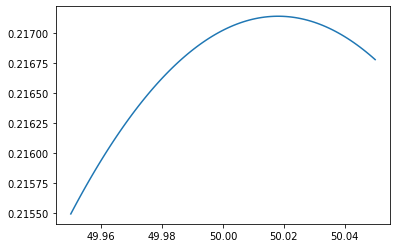

In [14]:
plt.plot(fs, freq_match(seconds[5])) ; plt.show()

In [15]:
best_freq(freq_match(s))

50.01767676767677

/var/folders/3x/6f7ftq8d55x7nlsmplp5yjzw0000gn/T/ipykernel_20663/1706248036.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


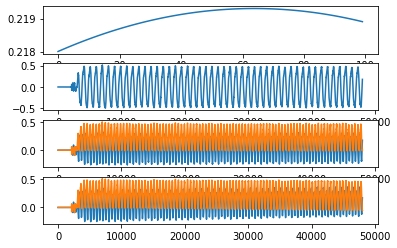

In [16]:
fig, (p1, p2, p3, p4) = plt.subplots(4, 1)
s = seconds[0]
p1.plot(freq_match(s))
p2.plot(s)
p3.plot((waves[50] * s).real)
p3.plot((waves[50] * s).imag)
p4.plot((waves[0] * s).real)
p4.plot((waves[0] * s).imag)
fig.show()

In [17]:
freqs = np.array([best_freq(freq_match(s)) for s in tqdm(seconds)])

100%|████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:04<00:00, 65.67it/s]


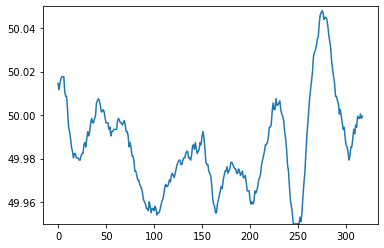

In [18]:
plt.ylim(F_START, F_STOP)
plt.plot(freqs)

In [30]:
# Load fingrid data
# From https://data.fingrid.fi/en/dataset/frequency-historical-data
frequency_data = np.zeros(0,)
dates = []

tz = pytz.timezone("EET")
def load_file(path):
    global frequency_data, start_time, end_time
    data = []
    with open(path) as f:
        reader = csv.reader(f, delimiter=',')
        next(reader) # skip header
        i = 0
        for row in reader:
            if i % 10 == 0:
                date = tz.localize(datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S.%f"))
                data.append(float(row[1]))
                dates.append(date)
            i += 1
        end_time = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S.%f")
    frequency_data = np.concatenate([frequency_data, data], axis=0)

for day in tqdm(range(31)):
    load_file(f"fingrid/2022-01/2022-01-{day+1:02}.csv")

100%|██████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:45<00:00,  1.48s/it]


In [31]:
mains = frequency_data

convs = []
for i in tqdm(range(len(mains)-len(freqs))):
    m = mains[i:i+len(freqs)]
    f = freqs
    sim = ((m - f)**2).sum()
    convs.append(sim)
convs = np.array(convs)
#convs = np.convolve(mains[::-1]-50, freqs-50, mode="valid")

100%|████████████████████████████████████████████████████████████████████████████| 2677202/2677202 [00:05<00:00, 486307.83it/s]


/var/folders/3x/6f7ftq8d55x7nlsmplp5yjzw0000gn/T/ipykernel_20663/1592394103.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


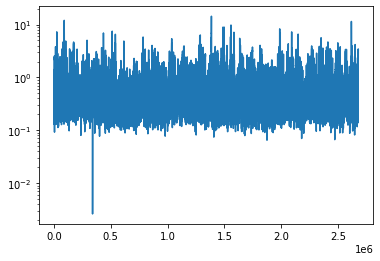

In [32]:
fig, p = plt.subplots()
p.set_yscale('log')
p.plot(convs)
fig.show()

In [33]:
# extract best
best_indices = np.argsort(convs)
shown = set()
for i in range(50):
    ind = best_indices[i]
    if any(abs(ind - s) < 100 for s in shown):
        continue
    shown.add(ind)
    score = convs[ind]
    print(f"#{i:2}: {ind} {score} {dates[ind]} -> {dates[ind] + snap_offset} = {(dates[ind] + snap_offset).timestamp()}")

# 0: 339960 0.0026187445158651667 2022-01-04 22:26:28+02:00 -> 2022-01-04 22:29:59+02:00 = 1641328199.0
#14: 1874310 0.06500249199060631 2022-01-22 16:47:33+02:00 -> 2022-01-22 16:51:04+02:00 = 1642863064.0
#17: 2470238 0.06649361320272923 2022-01-29 14:23:30.100000+02:00 -> 2022-01-29 14:27:01.100000+02:00 = 1643459221.1
#24: 2179270 0.06999128997040288 2022-01-26 05:31:58+02:00 -> 2022-01-26 05:35:29+02:00 = 1643168129.0
#33: 1406682 0.07432819906131653 2022-01-17 06:52:13.100000+02:00 -> 2022-01-17 06:55:44.100000+02:00 = 1642395344.1
#40: 401484 0.07733990613201906 2022-01-05 15:32:24+02:00 -> 2022-01-05 15:35:55+02:00 = 1641389755.0
#41: 978742 0.0774888960310109 2022-01-12 07:55:07+02:00 -> 2022-01-12 07:58:38+02:00 = 1641967118.0


339960


/var/folders/3x/6f7ftq8d55x7nlsmplp5yjzw0000gn/T/ipykernel_20663/1892089482.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


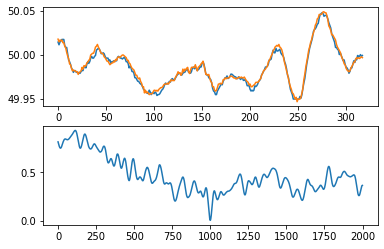

In [34]:
i = 339960
print(i)
fig, (p1, p2) = plt.subplots(2)

p1.plot(freqs)
p1.plot(mains[i:i+len(freqs)])
p2.plot(convs[i-1000:i+1000])
fig.show()

In [35]:
ts = 1641328199
for offset in range(-30, 31):
    print(f"SSM{{{ts+offset}}}")

SSM{1641328169}
SSM{1641328170}
SSM{1641328171}
SSM{1641328172}
SSM{1641328173}
SSM{1641328174}
SSM{1641328175}
SSM{1641328176}
SSM{1641328177}
SSM{1641328178}
SSM{1641328179}
SSM{1641328180}
SSM{1641328181}
SSM{1641328182}
SSM{1641328183}
SSM{1641328184}
SSM{1641328185}
SSM{1641328186}
SSM{1641328187}
SSM{1641328188}
SSM{1641328189}
SSM{1641328190}
SSM{1641328191}
SSM{1641328192}
SSM{1641328193}
SSM{1641328194}
SSM{1641328195}
SSM{1641328196}
SSM{1641328197}
SSM{1641328198}
SSM{1641328199}
SSM{1641328200}
SSM{1641328201}
SSM{1641328202}
SSM{1641328203}
SSM{1641328204}
SSM{1641328205}
SSM{1641328206}
SSM{1641328207}
SSM{1641328208}
SSM{1641328209}
SSM{1641328210}
SSM{1641328211}
SSM{1641328212}
SSM{1641328213}
SSM{1641328214}
SSM{1641328215}
SSM{1641328216}
SSM{1641328217}
SSM{1641328218}
SSM{1641328219}
SSM{1641328220}
SSM{1641328221}
SSM{1641328222}
SSM{1641328223}
SSM{1641328224}
SSM{1641328225}
SSM{1641328226}
SSM{1641328227}
SSM{1641328228}
SSM{1641328229}
